In [1]:
import pandas as pd
import os
import pickle
import numpy as np
from IPython.display import Image,display,HTML

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [2]:
path=r'D:\python data\movie_recommendation_project'

In [3]:
all_data=[]
for file in os.listdir(path):
    if 'all_data_' in file:
        data=pickle.load(open(os.path.join(path,file),'rb'))
        all_data=all_data+data
        
print(len(all_data))

105999


In [4]:
df=pd.DataFrame(all_data)

In [5]:
release_year=df['Year'].apply(lambda x:x.split('|')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')

length=df['Year'].apply(lambda x:x.split('|')[-1] if isinstance(x,str) else None)
length=length.apply(lambda x:
             int(x.split('h')[0])*60+int(x.split('h')[-1].split('m')[0]) if isinstance(x,str) and 'h' in x and 'm' in x else
             int(x.split('h')[0])*60 if isinstance(x,str) and 'h' in x and 'm' not in x else
             int(x.split('m')[0]) if isinstance(x,str) and 'h' not in x and 'm' in x else None

             )

df.insert(df.columns.get_loc('Year')+1,'Release Year',release_year)
df.insert(df.columns.get_loc('Year')+2,'Length in Min',length)
df=df.drop(columns='Year')

In [6]:
imdb_rating=df['Rating'].apply(lambda x:float(x.split('|')[0]) if isinstance(x,str) else None)

rating_count=df['Rating'].apply(lambda x:
                   float(x.split('|')[-1].replace('K',''))*10**3 if isinstance(x,str) and 'K' in x else
                   float(x.split('|')[-1].replace('M',''))*10**6 if isinstance(x,str) and 'M' in x else
                   float(x.split('|')[-1]) if isinstance(x,str) else None
                   )

df.insert(df.columns.get_loc('Rating')+1,'IMDB Rating',imdb_rating)
df.insert(df.columns.get_loc('Rating')+2,'Rating Count',rating_count)
df=df.drop(columns='Rating')

In [7]:
df=df.drop(columns='Summary')

In [8]:
df['Director'][0]

'Director|Urban Gad|Writers|Urban Gad|Gebhard Schätzler-Perasini|Stars|Asta Nielsen|Valdemar Psilander|Gunnar Helsengreen'

In [9]:
import re

def get_director(text):
    try:
        return re.search(r'(?:Director|Directors)\|(.*?)(?:\|Writer|Writers|Star|Stars)\|', text).group(1)
    except:
        None


def get_writer(text):
    try:
        return re.search(r'(?:Writer|Writers)\|(.*?)(?:\|Star|Stars)\|', text).group(1)
    except:
        None

def get_star(text):
    try:
        return re.search(r'(?:Star|Stars)\|(.*)', text).group(1)
    except:
        None



directors=df['Director'].apply(lambda x:get_director(x) if isinstance(x,str) else None)
writers=df['Director'].apply(lambda x:get_writer(x) if isinstance(x,str) else None)
stars=df['Director'].apply(lambda x:get_star(x) if isinstance(x,str) else None)


df.insert(df.columns.get_loc('Director')+1,'Directors',directors)
df.insert(df.columns.get_loc('Director')+2,'Writers',writers)
df.insert(df.columns.get_loc('Director')+3,'Stars',stars)
df=df.drop(columns='Director')


In [10]:
df.isna().mean()*100

Movie URL        0.000000
Title            0.051887
Poster           0.267927
Release Year     0.058491
Length in Min    1.564166
IMDB Rating      0.053774
Rating Count     0.053774
Plot             0.051887
Directors        0.590572
Writers          5.027406
Stars            0.940575
Genres           0.147171
dtype: float64

In [ ]:
#df.to_csv('movies.csv',index=False)

# Visualization

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<Axes: title={'center': 'Number of movies by genre'}>

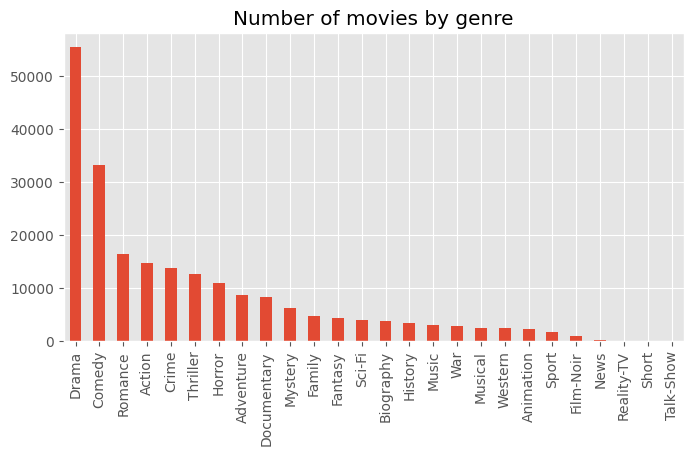

In [13]:
pd.Series([genre for genres in df['Genres'].str.split('|') if genres for genre in genres]).value_counts()\
    .plot.bar(figsize=(8,4),title='Number of movies by genre')

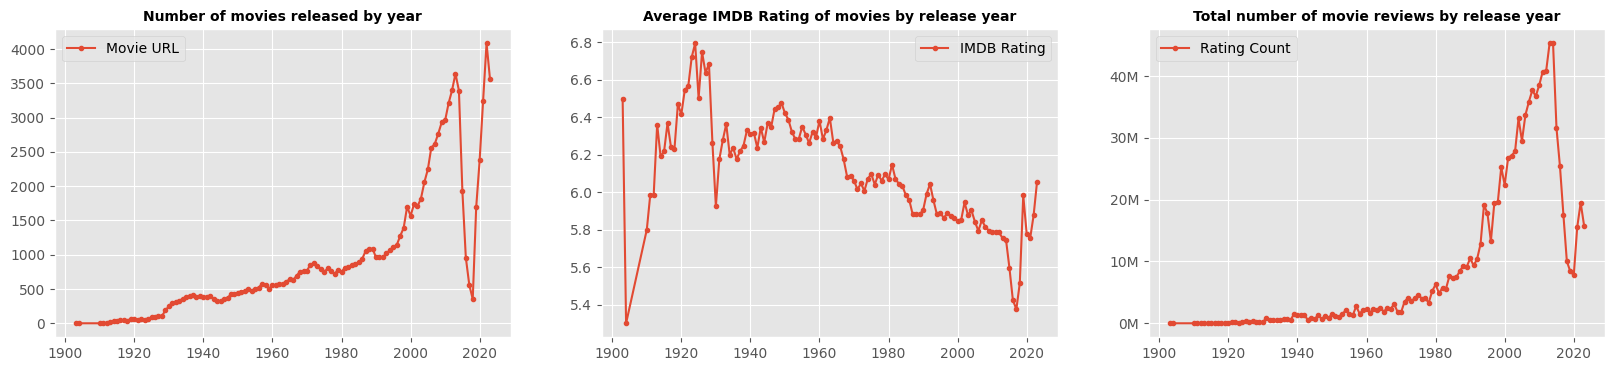

In [26]:
import matplotlib.ticker as ticker

g=df.groupby('Release Year').agg({'IMDB Rating':'mean','Rating Count':'sum','Movie URL':'count'})

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,4))

g.plot(ax=ax1,marker='.',y='Movie URL')
ax1.set_title('Number of movies released by year',fontweight='bold',size=10)
ax1.set_xlabel(None)

g.plot(ax=ax2,marker='.',y='IMDB Rating')
ax2.set_title('Average IMDB Rating of movies by release year',fontweight='bold',size=10)
ax2.set_xlabel(None)

g.plot(ax=ax3,marker='.',y='Rating Count')
ax3.set_title('Total number of movie reviews by release year',fontweight='bold',size=10)
ax3.set_xlabel(None)

formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}M'.format(x / 1000000))
ax3.yaxis.set_major_formatter(formatter)

plt.show()

In [15]:
df['Directors']=df['Directors'].apply(lambda x: sorted([i.strip() for i in x.split('|') if i.strip()]) if isinstance(x, str) else None)
df['Directors']=df['Directors'].apply(lambda x:', '.join(x) if isinstance(x,list) else None)

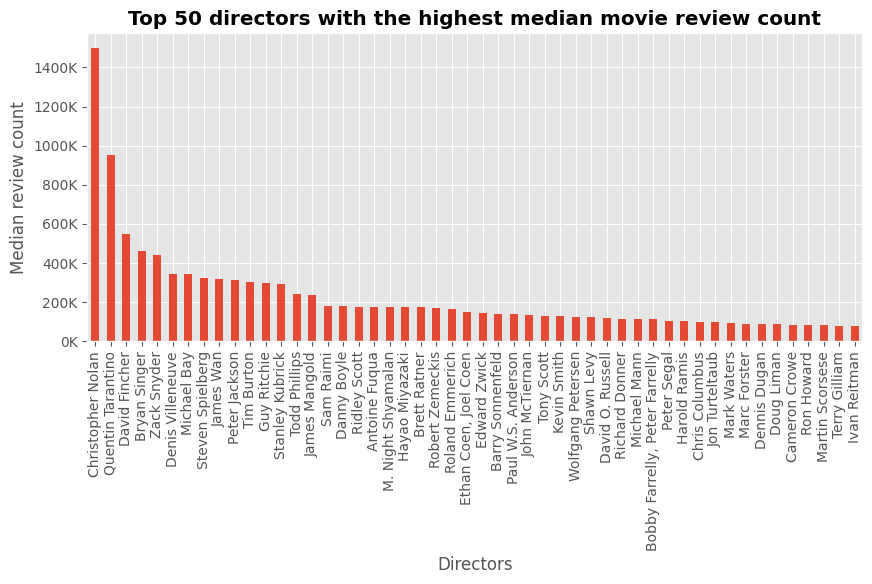

In [16]:
g=df.groupby('Directors').filter(lambda x:x['Movie URL'].count()>=10)\
    .groupby('Directors')['Rating Count'].median().sort_values(ascending=False).head(50)

fig,ax=plt.subplots(figsize=(10,4))
g.plot.bar(ax=ax)
ax.set_title('Top 50 directors with the highest median movie review count',fontweight='bold')
ax.set_ylabel('Median review count')

formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}K'.format(x / 1000))
ax.yaxis.set_major_formatter(formatter)

plt.show()